In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

In [0]:
from pathlib import Path
import re
import importlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
import tensorflow_hub as hub
# Reduce logging output
from absl import logging
logging.set_verbosity(logging.ERROR)

In [0]:
# Inference model
MODULE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# Inference batch size
MAX_BATCH_SIZE = 1024

In [0]:
MAIN_DIR = Path('drive/My Drive/Colab Notebooks/transformers/MoviePlots')
CACHE_DIR = MAIN_DIR/'text_generation'/'eval_cache'
CACHE_DIR.mkdir(exist_ok=True)

DATA_FILE = MAIN_DIR/'data'/'data.pkl'

MODEL_DIR = MAIN_DIR/'text_generation'/'GPT-2-gpt2simple'
DUMPS_DIR = MODEL_DIR/'dumps'

## Import training data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    train_data = pickle.load(handle)

In [8]:
train_df = pd.DataFrame(train_data)

print(train_df.head())

                                               title  ...                      secondary
0                               "#7DaysLater" (2013)  ...                           None
1       "#BlackLove" (2015) {Crash the Party (#1.9)}  ...                Crash the Party
2  "#BlackLove" (2015) {Making Lemonade Out of Le...  ...  Making Lemonade Out of Lemons
3      "#BlackLove" (2015) {Miss Independent (#1.5)}  ...               Miss Independent
4     "#BlackLove" (2015) {Sealing the Deal (#1.10)}  ...               Sealing the Deal

[5 rows x 7 columns]


## Parse dumps

In [9]:
# Import title_extractor
spec = importlib.util.spec_from_file_location('title_extractor', MAIN_DIR/'title_extractor.py')
title_extractor = importlib.util.module_from_spec(spec)
spec.loader.exec_module(title_extractor)
title_extractor

<module 'title_extractor' from 'drive/My Drive/Colab Notebooks/transformers/MoviePlots/title_extractor.py'>

In [0]:
BOS_TOKEN = '<|startoftext|>'
EOS_TOKEN = '<|endoftext|>'
EOG_TOKEN = '|0|'
EOT_TOKEN = '|1|'

In [11]:
dump_files = list(DUMPS_DIR.glob('*.txt'))

dump_files

[PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-gpt2simple/dumps/temp_0_7_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-gpt2simple/dumps/temp_0_7_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-gpt2simple/dumps/temp_1_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-gpt2simple/dumps/temp_1_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-gpt2simple/dumps/temp_1_3_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-gpt2simple/dumps/temp_1_3_topp_0_9.txt')]

In [0]:
def extract_data(line):
    """Extract the data from a line generated by the model."""
    main = line.split(BOS_TOKEN)[1].split(EOS_TOKEN)[0]
    genre = main.split(EOG_TOKEN)[0].strip()
    title = main.split(EOG_TOKEN)[1].split(EOT_TOKEN)[0].strip()
    plot = main.split(EOG_TOKEN)[1].split(EOT_TOKEN)[1].strip()
    return {
        'genre': genre,
        'title': title,
        'plot': plot,
        'year': title_extractor.extract_year(title),
        'episode': title_extractor.extract_episode(title),
        'primary': title_extractor.extract_primary_title(title),
        'secondary': title_extractor.extract_secondary_title(title)
    }

In [0]:
def parse_fname(fname):
    """Parse the name of a file for temperature and top_p."""
    pattern = r'temp_(.+)_topp_(.+).txt'
    match = re.search(pattern, dump_files[0].name)
    temp, topp = match.groups()
    temp = float(temp.replace('_', '.'))
    topp = float(topp)
    return temp, topp

In [14]:
gen_data = []
for dump_file in dump_files:
    with dump_file.open() as f:
        for line in f:
            try:
                data_dict = extract_data(line)
                temp, topp = parse_fname(dump_file.name)
                data_dict['temp'] = temp
                data_dict['topp'] = topp
                gen_data.append(data_dict)
            except:
                pass

print(len(gen_data))

1650


In [15]:
gen_df = pd.DataFrame(gen_data)

print(gen_df.head())

    genre                                              title  ... temp  topp
0  action             "Fame" (1982) {The Sea Inside (#5.20)}  ...  0.7   0.0
1  action                "Identity" (1960) {Myrville (#2.4)}  ...  0.7   0.0
2  action        "Blue Heelers" (1994) {Burning Up (#15.34)}  ...  0.7   0.0
3  action  "The Untouchables" (1959) {The Queen's Lament ...  ...  0.7   0.0
4  action  "Mystery Science Theater 3000" (1988) {The Ali...  ...  0.7   0.0

[5 rows x 9 columns]


## Calculate similarity

### Jaccard similarity

In [0]:
def jaccard_similarity(str1, str2):
    """Jacard similarity, or, how overfit is our data?..."""
    s1 = set(str1.split(' '))
    s2 = set(str2.split(' '))
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [0]:
def similarity_matrix(column, similarity_func, overwrite=False):
    """Calculate the pairwise similarity between texts of two lists."""
    # It's important to preserve the order of columns and index to compare multiple matrices later
    fpath = CACHE_DIR/(column + '.npy')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        return np.load(fpath)
    pbar = tqdm(total=len(gen_df.index)*len(train_df.index))
    # Fill similarity matrix
    sim_matrix = np.empty((len(gen_df.index), len(train_df.index)))
    sim_matrix[:, :] = np.nan
    for i, t1 in enumerate(gen_df[column]):
        for j, t2 in enumerate(train_df[column]):
            if t1 not in (None, '') and t2 not in (None, ''):
                sim_matrix[i, j] = similarity_func(t1, t2)
            pbar.update()
    pbar.close()
    np.save(fpath, sim_matrix)
    return sim_matrix

In [18]:
# Primary title similarity
primary_jm = similarity_matrix('primary', jaccard_similarity)

Loading from cache...


In [19]:
# Secondary title similarity
secondary_jm = similarity_matrix('secondary', jaccard_similarity)

Loading from cache...


In [20]:
# Plot similarity
plot_jm = similarity_matrix('plot', jaccard_similarity)

Loading from cache...


### Universal sentence encoder

In [0]:
# Load inference model
model = hub.load(MODULE_URL)

In [0]:
def compute_embeddings(texts, fname, overwrite=False):
    """Compute a representation for each text."""
    fpath = CACHE_DIR/fname
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        return np.load(fpath)
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE)):
        embeddings.append(np.array(model(texts[i:i+BATCH_SIZE])))
    embeddings = np.vstack(embeddings)
    assert(embeddings.shape[0] == len(texts))
    np.save(fpath, embeddings)
    return embeddings

In [22]:
gen_plot_embeddings = compute_embeddings(gen_df['plot'], 'gen_plot_embeddings.npy')

Loading from cache...


In [23]:
train_plot_embeddings = compute_embeddings(train_df['plot'], 'train_plot_embeddings.npy')

Loading from cache...


In [24]:
%%time
# Compute pairwise similarity
plot_em = np.inner(gen_plot_embeddings, train_plot_embeddings)

print(plot_em.shape)

(1650, 117193)
CPU times: user 6.39 s, sys: 498 ms, total: 6.89 s
Wall time: 2.4 s


### Stack matrices

In [25]:
# Stack matrices together
jm = np.stack([primary_jm, secondary_jm, plot_jm, plot_em], axis=2)

print(jm.shape)

(1650, 117193, 4)


In [0]:
# Release RAM
del primary_jm
del secondary_jm
del plot_jm

In [27]:
# Some generated titles/plots are empty or NaN
# Do not check secondary titles since they are allowed to be empty
primary_valid_mask = gen_df['primary'].apply(lambda x: x not in (None, ''))
plot_valid_mask = gen_df['plot'].apply(lambda x: x not in (None, ''))
valid_mask = primary_valid_mask & plot_valid_mask

jm = jm[valid_mask, :, :]

print(jm.shape)

(1643, 117193, 4)


## Evaluate similarity

In [28]:
# The most similar and dissimilar generated titles
jm_max_df = pd.DataFrame(np.nanmax(jm, axis=1), columns=['primary_j', 'secondary_j', 'plot_j', 'plot_e''])

print(jm_max_df.head())

   primary_j  secondary_j    plot_j    plot_e
0        1.0     0.500000  0.187500  0.543720
1        1.0     0.000000  0.180000  0.640631
2        1.0     1.000000  0.175824  0.720705
3        1.0     0.500000  0.225806  0.656921
4        1.0     0.666667  0.157303  0.695455


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


In [29]:
# The relative number of NaNs among each part
jm_max_df.isnull().mean()

primary_j      0.000000
secondary_j    0.285453
plot_j         0.000000
plot_e         0.000000
dtype: float64

In [30]:
jm_max_df.index = gen_df.loc[valid_mask, 'primary'].tolist()

print(jm_max_df['primary_j'].sort_values())

Ville city                   0.0
Koppa There!!                0.0
Siebold                      0.0
Trippers                     0.0
EssenceisSploit              0.0
                            ... 
The Last Enemy               1.0
The Outer Limits             1.0
Alfred Hitchcock Presents    1.0
River City                   1.0
Iron Horse                   1.0
Name: primary_j, Length: 1643, dtype: float64


In [31]:
jm_max_df.index = gen_df.loc[valid_mask, 'secondary'].tolist()

# Select only titles 
print(jm_max_df.loc[~jm_max_df['secondary_j'].isnull(), 'secondary_j'].sort_values())

Cybernatusgeist          0.0
W.I.T.C.O.R.L.           0.0
Raklo                    0.0
Thoren Kresscht          0.0
Tsuyokuteki-san          0.0
                        ... 
The Big Fix              1.0
Pilot                    1.0
The Big Move             1.0
The Contender: Part 2    1.0
Big Ol' Katie            1.0
Name: secondary_j, Length: 1174, dtype: float64


In [32]:
jm_max_df.index = gen_df.loc[valid_mask, 'plot'].tolist()

print(jm_max_df['plot_j'].sort_values())

122}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [33]:
jm_max_df.index = gen_df.loc[valid_mask, 'plot'].tolist()

print(jm_max_df['plot_e'].sort_values())

122}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   0.239142
Hear Crossing (#3.76)}                  

In [34]:
# The average similarity of generated titles to the real ones
jm_max_df.mean(axis=0)

primary_j      0.748339
secondary_j    0.573215
plot_j         0.158318
plot_e         0.601752
dtype: float64

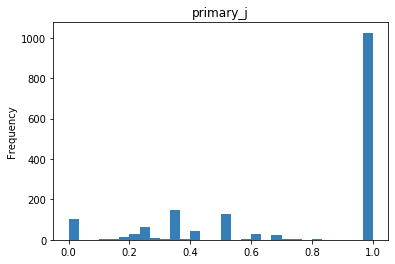

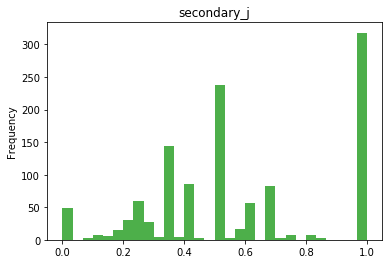

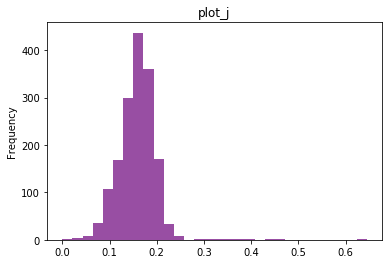

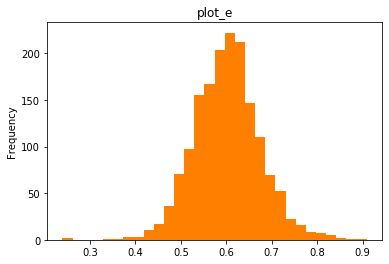

In [54]:
jm_max_df['primary_j'].plot.hist(bins=30, title='primary_j', color=plt.cm.Set1(0.15))
plt.show()
jm_max_df['secondary_j'].plot.hist(bins=30, title='secondary_j', color=plt.cm.Set1(0.25))
plt.show()
jm_max_df['plot_j'].plot.hist(bins=30, title='plot_j', color=plt.cm.Set1(0.35))
plt.show()
jm_max_df['plot_e'].plot.hist(bins=30, title='plot_e', color=plt.cm.Set1(0.45))
plt.show()

In [55]:
# The number of exact matches
(jm_max_df == 1).mean(axis=0)

primary_j      0.623859
secondary_j    0.193548
plot_j         0.000000
plot_e         0.000000
dtype: float64

In [56]:
# Correlation of similarities on different stages
pd.DataFrame({'primary_j': jm[:, :, 0].flatten(), 
              'secondary_j': jm[:, :, 1].flatten(), 
              'plot_j': jm[:, :, 2].flatten(), 
              'plot_e': jm[:, :, 3].flatten()}).corr()

,primary_j,secondary_j,plot_j,plot_e
primary_j,1.000000,0.052413,0.053132,0.025089
secondary_j,0.052413,1.000000,0.074913,0.015444
plot_j,0.053132,0.074913,1.000000,0.311560
plot_e,0.025089,0.015444,0.311560,1.000000


### Grouped by genre

In [0]:
# Extract genre masks
genre_masks = {}
for genre, group in gen_df[valid_mask].groupby(by='genre'):
    gen_mask = gen_df[valid_mask].index.isin(group.index).tolist()
    train_mask = train_df['genres'].apply(lambda x: genre in x).tolist()
    genre_masks[genre] = np.asarray(gen_mask), np.asarray(train_mask)

In [59]:
# How similar are generated texts to training texts with respect to each genre?
print(pd.DataFrame({
    genre: np.nanmean(np.nanmax(jm[gen_mask, :, :][:, train_mask, :], axis=1), axis=0)
    for genre, (gen_mask, train_mask) in genre_masks.items() 
    if any(gen_mask) and any(train_mask)
}, index=['primary_j', 'secondary_j', 'plot_j', 'plot_e']).transpose().sort_values(by='primary_j', ascending=False))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


             primary_j  secondary_j    plot_j    plot_e
drama         0.798030     0.585979  0.167387  0.641928
romance       0.763429     0.426515  0.159327  0.636315
crime         0.733611     0.601570  0.153999  0.621726
mystery       0.651238     0.634551  0.151912  0.604357
news          0.649691     0.359418  0.131017  0.525459
western       0.637500     0.358539  0.149348  0.577934
thriller      0.609342     0.519841  0.151473  0.594021
adventure     0.598810     0.436348  0.149047  0.574467
action        0.594259     0.462236  0.153229  0.589455
sci-fi        0.569009     0.441972  0.149140  0.569391
comedy        0.552771     0.433793  0.158876  0.585240
reality-tv    0.550159     0.389647  0.140505  0.552267
talk-show     0.524680     0.262398  0.127820  0.521075
fantasy       0.517756     0.424105  0.144957  0.555220
family        0.511574     0.384324  0.151558  0.555472
documentary   0.477724     0.385873  0.131051  0.529697
animation     0.476706     0.344066  0.143479  0

In [60]:
# Here is the true distribution the model was trained on
# If both distribution are similar, than the model established the link between genre and title properly
# It also shows which genres are the most expressive
pd.Series([genre for genres in train_df['genres'] for genre in genres]).value_counts()

drama          45890
comedy         33870
romance        19174
family         15403
crime          15120
action         12376
reality-tv     12336
mystery        12025
documentary    12020
animation      11369
adventure      10243
thriller        8852
sci-fi          8658
fantasy         7103
talk-show       5253
news            3945
music           2837
western         2761
history         2662
horror          2571
game-show       2045
sport           1946
war             1407
biography       1385
musical          595
short            578
adult             61
dtype: int64

### Per item similarity difference

In [61]:
# Capture how similarity changed from primary to secondary title
jm_diff = jm[:, :, 1]-jm[:, :, 0]

print(jm_diff.shape)

(1643, 117193)


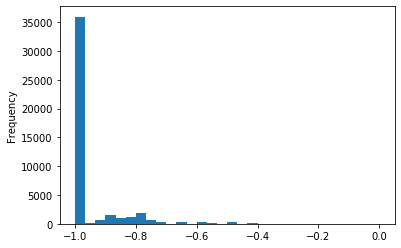

In [62]:
# How similarity changed from perfectly identical primary plots to secondary plots
pd.Series(jm_diff[jm[:, :, 0] == 1]).plot.hist(bins=30)

In [63]:
# If primary titles are identical, how many secondary titles are identical too?
(jm_diff[jm[:, :, 0] == 1] == 0).mean()

0.0005217583255571275

### The most similar example

In [0]:
# Display the most similar examples according to universal embeddings
gen_i, train_i = np.unravel_index(np.nanargmax(jm[:, :, 3]), jm.shape[:2])

In [66]:
jm[gen_i, train_i, :]

array([1.        ,        nan, 0.64444444, 0.90938878])

In [67]:
print(gen_df[valid_mask].iloc[gen_i])
print(gen_df[valid_mask].iloc[gen_i]['plot'])

genre                                                lifestyle
title                 "The Hollywood Squares" (1965) {(#3.69)}
plot         "THE HOLLYWOOD SQUARES" Welcomes 9 New Stars a...
year                                                      1965
episode                                                   3.69
primary                                  The Hollywood Squares
secondary                                                     
temp                                                       0.7
topp                                                         0
Name: 148, dtype: object
"THE HOLLYWOOD SQUARES" Welcomes 9 New Stars are Actor-Singer-Comedian ROBERT MORSE, Actress-Singer JAYNE MEADOWS, CHARLEY WEAVER, ABBY DALTON, "THE UNDERDOG SHOW's" MR. WALLY COX, "THE DICK VAN DYKE SHOW's" ROSE MARIE, Actor-Singer VEDDY DOUG & "Bewitched's" PAUL LYNDE.


In [68]:
print(train_df.iloc[train_i])
print(train_df.iloc[train_i]['plot'])

title                "The Hollywood Squares" (1965) {(#2.134)}
plot          "THE HOLLYWOOD SQUARES" Welcomes 9 New Stars ...
genres                             {comedy, game-show, family}
year                                                      1965
episode                                                  2.134
primary                                  The Hollywood Squares
secondary                                                     
Name: 95575, dtype: object
 "THE HOLLYWOOD SQUARES" Welcomes 9 New Stars are Actor-Singer-Songwriter-Comedian-Pianist-Author-TV Host STEVE ALLEN, Actress-Singer JAYNE MEADOWS, CHARLEY WEAVER, ABBY DALTON, "THE UNDERDOG SHOW's" MR. WALLY COX, "THE DICK VAN DYKE SHOW's" ROSE MARIE, Actor-Comedian JACK CARTER, Actor-Comedian DON RICKLES & "Bewitched's" PAUL LYNDE.
